In [1]:
##{{{ imports gpu

from __future__ import absolute_import
from __future__ import print_function
import keras
import pickle
import numpy as np
import random
import importlib

# from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Flatten, Lambda
from keras.layers import Conv2D, Activation, AveragePooling2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras import backend as K
from keras.regularizers import l2
import itertools
import numpy as np
import tensorflow as tf
from keras.datasets import mnist
import matplotlib.pyplot as plt
import siamesa_data_processing as sdp  # --> importo mi script para generar dataset
import os
import re
import plotter as p
import test_set_from_pkl
import metricas
import importlib

# physical_devices = tf.config.experimental.list_physical_devices("GPU")
# print(physical_devices)  # nice

# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
##}}}


Using TensorFlow backend.
/home/ttdduu/miniconda3/envs/tf_spherical/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'
/home/ttdduu/miniconda3/envs/tf_spherical/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/ttdduu/miniconda3/envs/tf_spherical/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silenc

In [2]:
##{{{ generar nuevos splits de train, valid (para monitorear acc) y test en dir default

importlib.reload(sdp)


def crear_carpeta_sets(path_general_entrenamientos):
    # Get a list of directories in the specified path
    subdirectories = [
        name
        for name in os.listdir(path_general_entrenamientos)
        if os.path.isdir(os.path.join(path_general_entrenamientos, name))
    ]

    # Extract numbers from directory names
    numbers = []
    for name in subdirectories:
        match = re.match(r"^(\d+)", name)
        if match:
            numbers.append(int(match.group(1)))

    # Find the maximum number
    max_number = max(numbers) if numbers else 0

    # Create a new directory with the incremented number
    new_directory_name = str(max_number + 1)
    new_directory_path = os.path.join(path_general_entrenamientos, new_directory_name)
    os.mkdir(new_directory_path)
    return new_directory_path

tipo = "alfa"

# dónde voy a guardar los train y test sets
path_general_entrenamientos = f"/home/ttdduu/lsd/tesislab/entrenamientos/{tipo}"


tr_name, tr_split = "train_set", 0.5
# val_name, val_split = '...', ... # si quisiera generar un validation split para monitorear acc
test_name = "test_set"
path_del_entrenamiento = crear_carpeta_sets(
    path_general_entrenamientos
)  # el directory donde quiero que se guarden los diccionarios que estoy por generar (train y test sets), y los plots y base_network si quisiera guardarlos
if tipo =="alfa":

    base_path = f"/home/ttdduu/lsd/tesislab/datos/pitches/alfa_dpi50"  # el directory donde están los pitches
    individuals = [
    "A_aug",
    "B_aug",
    "19_aug",
    "23_aug",
    "34_aug",
    "HAC1_aug",
    "HAC2_aug",
    "HEC1_aug",
    ]

else:
    base_path = f"/home/ttdduu/lsd/tesislab/datos/pitches/{tipo}"  # el directory donde están los pitches
    
    individuals = [
        "A",
        "B",
        "19",
        "23",
        "34",
        "AC1",
        "AC2",
        "EC1",
    ]


sdp.datos_splits(
    [tr_name, tr_split],
    test_name,
    individuals=individuals,
    base_path=base_path,
    sets_path=path_del_entrenamiento,
)  # generar los splits (en formato diccionario) llamando a la func datos_splits de siamesa_data_processing.py

##}}}


dictionary test saved successfully to file
largo del dict de train o valid: 22155
dictionary saved successfully to file


In [3]:
##{{{ importar dicts recién creados

tr_pkl = f"{path_del_entrenamiento}/{tr_name}.pkl"
# val_pkl = f'{dicts}/{carpeta_sets}/{val_name}.pkl'
test_pkl = f"{path_del_entrenamiento}/{test_name}.pkl"


def opd(path):  # open dict
    with open(path, "rb") as fp:
        dict_name = pickle.load(fp)
    return dict_name


# val_dict = opd(val_pkl)
tr_dict, test_dict = opd(tr_pkl), opd(test_pkl)

unique_letters = set()
for sublist in tr_dict.values():
    last_two_letters = sublist[1:]
    unique_letters.update(last_two_letters)
print(f"indivs para train: {unique_letters}")

print(f"indivs para test: {test_dict.keys()}")

##}}}


indivs para train: {'23_aug', 'HAC2_aug', 'A_aug', '34_aug', '19_aug', 'HAC1_aug', 'HEC1_aug', 'B_aug'}
indivs para test: dict_keys(['A_aug', 'B_aug', '19_aug', '23_aug', '34_aug', 'HAC1_aug', 'HAC2_aug', 'HEC1_aug'])


In [4]:
##{{{ tr, val, test sets


# {{{ dict_to_set con la opción de generar un modelo nulo
#
def dict_to_set(
    dictio,
):  # recibe el dict {[sílaba 1, sílaba 2]: [0 o 1 si son o no el mismo individuo, 'nombre de individuo 1', 'nombre de individuo 2']}
    x = np.array(
        [
            [tensor.numpy() for tensor in sublist]
            for sublist in list(map(list, [i for i in dictio.keys()]))
        ],
        dtype=np.uint8,
    )
    n = x.shape[0]
    indices = np.arange(n)
    np.random.shuffle(indices)
    pairs = x[indices]
    pairs = pairs.reshape(pairs.shape + (1,))
    target = np.array(list(dictio.values()))[indices]
    y = target[:, 0]  # 0 o 1
    belong_to = target[:, 1:]  # ['nombre de individuo 1', 'nombre de individuo 2']
    # print(x.shape, y.shape)
    return [pairs, y, belong_to]


def dict_to_set_nulo(dictio):
    x = np.array(
        [
            [tensor.numpy() for tensor in sublist]
            for sublist in list(map(list, [i for i in dictio.keys()]))
        ],
        dtype=np.uint8,
    )
    n = x.shape[0]
    indices = np.arange(n)
    np.random.shuffle(indices)
    pairs = x[indices]
    pairs = pairs.reshape(pairs.shape + (1,))
    target = np.array(list(dictio.values()))[indices]
    belong_to = target[:, 1:]
    y = target[:, 0]
    np.random.shuffle(y)  # randomizo los labels
    # print(x.shape, y.shape)
    return [pairs, y, belong_to]


# }}}
# {{{ def make_train_set(val=False, nulo=False):
def make_train_set(val=False, nulo=False):
    # if val == True:
    # tr_pairs, tr_y, tr_tensors_belong_to = dict_to_set(tr_dict)
    # val_pairs, val_y, val_tensors_belong_to = dict_to_set(val_dict)
    # return (
    # tr_pairs,
    # tr_y,
    # tr_tensors_belong_to,
    # val_pairs,
    # val_y,
    # val_tensors_belong_to,
    # )
    # else:
    # tr_pairs, tr_y, tr_tensors_belong_to = dict_to_set(tr_dict)
    # return tr_pairs, tr_y, tr_tensors_belong_to

    if nulo == True:
        tr_pairs_nulo, tr_y_nulo, tr_tensors_belong_to_nulo = dict_to_set_nulo(tr_dict)
        return tr_pairs_nulo, tr_y_nulo, tr_tensors_belong_to_nulo
    else:
        tr_pairs, tr_y, tr_tensors_belong_to = dict_to_set(tr_dict)
        return tr_pairs, tr_y, tr_tensors_belong_to


# }}}

test_set, test_tensors_belong_to = test_set_from_pkl.make_test_set(
    test_dict
)  # lo defino fuera de make_sets porque podría tener más de un test_set que tengo que concatenar
tr_pairs, tr_y, tr_tensors_belong_to = make_train_set(nulo=False)


def limitar_numero_test_samples(individuo, test_set, test_tensors_belong_to):
    indexes_individuo = np.where(test_tensors_belong_to == individuo)[0]
    np.random.shuffle(indexes_individuo)
    random_indices, leftovers = indexes_individuo[:50], indexes_individuo[50:]
    test_set, test_tensors_belong_to = np.delete(
        test_set, leftovers, axis=0
    ), np.delete(test_tensors_belong_to, leftovers, axis=0)
    return test_set, test_tensors_belong_to


##}}}


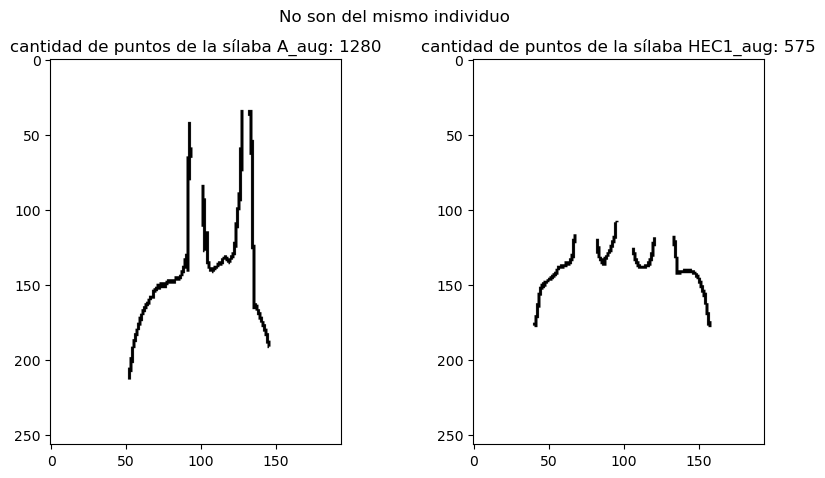

In [5]:
##{{{ def visualize_image_from_tensor(nro_de_par): # confirmo que pares de datos están bien con sus labels


def visualize_image_from_tensor(nro_de_par):
    respuesta = "Sí" if tr_y[nro_de_par] == "1" else "No"
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Adjust figsize as needed
    fig.suptitle(f"{respuesta} son del mismo individuo")
    for i, tensor in enumerate(tr_pairs[nro_de_par]):
        img_array = tensor.astype("uint8")
        img_array = 1 - img_array
        ax = axes[i]
        ax.imshow(img_array, cmap="binary", vmin=0, vmax=1)
        ax.set_title(
            f"cantidad de puntos de la sílaba {tr_tensors_belong_to[nro_de_par][i]}: {len(tensor[tensor==0])}"
        )
    plt.show()


nro_de_par = np.random.randint(len(tr_pairs))
visualize_image_from_tensor(nro_de_par)

##}}}


In [7]:
##{{{ def create_base_net(input_shape): # chollet 2ed pag 216:

from tensorflow.keras.layers import BatchNormalization


def create_base_net(input_shape):  # chollet 2ed pag 216
    input = Input(shape=input_shape)
    x = Conv2D(
        filters=32, kernel_size=3, activation="relu", kernel_regularizer=l2(2e-10)
    )(input)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(
        filters=64, kernel_size=3, activation="relu", kernel_regularizer=l2(2e-10)
    )(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(
        filters=128, kernel_size=3, activation="relu", kernel_regularizer=l2(2e-10)
    )(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(
        filters=64, kernel_size=3, activation="relu", kernel_regularizer=l2(2e-10)
    )(x)
    x = Flatten()(x)
    # transformo linealmente la representación aplanada de la última capa convolucional usando una capa
    # densa; el embedding de salida tiene 3 dimensiones y su activación es lineal (no se le computa una
    # función de activación).
    x = Dense(3, activation="linear")(x)
    # el vector es normalizado entre -1 y 1 --> en una red entrenada, la cual separa clases distintas lo más
    # posible según la función costo contrastiva, los embeddings de cada sílaba (es decir, cada punto)
    # son ubicados en la superficie de una esfera unitaria.
    x = Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)
    model = Model(input, x)
    model.summary()
    return model


##}}}


In [ ]:
##{{{ la parte siamesa de la red: llamarla una vez para cada input de los pares.

dimx, dimy = 194, 257  # los dicts que voy a importar van a ser de este size siempre
input_shape = (dimy, dimx, 1)
base_network = create_base_net(input_shape)
input_a = Input(input_shape)
input_b = Input(input_shape)
processed_a = base_network(input_a)
processed_b = base_network(input_b)

L1_layer = Lambda(lambda tensors: tensors[0] - tensors[1])
L1_distance = L1_layer([processed_a, processed_b])
vector_norm = keras.layers.dot(
    [L1_distance, L1_distance], axes=1
)  # replacing euclidean distance with inner products. es lo mismo.
encoder = Model([input_b], processed_b)  # codificador para emplear la red
siamese_net = Model([input_a, input_b], vector_norm)  # modelo completo

##}}}


In [ ]:
##{{{ def contrastive_loss(y_true, y_pred):


def contrastive_loss(y_true, y_pred):
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)


optimizer = tf.keras.optimizers.Adam(0.01)

##}}}


In [ ]:
##{{{ def save_net(descripcion=descripcion):


def save_net(descripcion):
    base_network.save(f"{path_del_entrenamiento}/base_network{descripcion}.h5")


##}}}


In [ ]:
##{{{ compile

margin = 0.6
siamese_net.compile(loss=contrastive_loss, optimizer=optimizer)

##}}}


In [ ]:
##{{{ fit

# siamese_net.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y, batch_size=1, epochs=epochs, validation_data=([val_pairs[:, 0], val_pairs[:, 1]], val_y))
epochs = 20
siamese_net.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y, batch_size=20, epochs=epochs)

## }}}
